In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('D:/Guvi-Loan Deafault Preiction Project/loan_default_prediction_project_complete.csv')

In [3]:
# Impute missing values with 'Unknown'
df['Gender'].fillna('Unknown', inplace=True)

print(df['Gender'].isnull().sum()) 

0


C:\Users\Admin\AppData\Local\Temp\ipykernel_2096\2774894870.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna('Unknown', inplace=True)


In [4]:
# Impute missing values with 'Unknown'
df['Employment_Status'].fillna('Unknown', inplace=True)

print(df['Employment_Status'].isnull().sum())

0


C:\Users\Admin\AppData\Local\Temp\ipykernel_2096\1612455751.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Employment_Status'].fillna('Unknown', inplace=True)


In [5]:
# List of ordinal categorical columns to be label encoded
ordinal_columns = ['Employment_Status']  # Example, adjust based on your dataset

# Apply Label Encoding
label_encoders = {}
for col in ordinal_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the label encoder for future use or inverse transformation

# List of nominal categorical columns to be one-hot encoded
nominal_columns = ['Gender', 'Location']  # Example, adjust based on your dataset

# One-Hot Encoding without dropping the first column to understand the full set of generated features
encoder = OneHotEncoder(sparse_output=False, drop=None)  # **Keep all categories**
encoded_features = encoder.fit_transform(df[nominal_columns])

# Inspect the shape and content of encoded features
encoded_feature_names = encoder.get_feature_names_out(nominal_columns)
print("Encoded feature names:", encoded_feature_names)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine encoded features with the original DataFrame, excluding the original nominal columns
df_encoded = pd.concat([df.drop(nominal_columns, axis=1), encoded_df], axis=1)

# Encode the target variable 'Loan_Status'
le_status = LabelEncoder()
df_encoded['Loan_Status'] = le_status.fit_transform(df_encoded['Loan_Status'])

# Display the final DataFrame
print(df_encoded)

Encoded feature names: ['Gender_Female' 'Gender_Male' 'Gender_Unknown' 'Location_Rural'
 'Location_Suburban' 'Location_Urban']
      Age        Income  Employment_Status  Credit_Score  \
0      56  91910.323246                  0           615   
1      46  81880.547904                  2           702   
2      32  89696.082903                  1           747   
3      60  37123.175342                  2           846   
4      25  67655.479665                  1           425   
...   ...           ...                ...           ...   
9995   33  94318.593216                  0           359   
9996   29  22480.468746                  0           671   
9997   18  88172.496665                  0           441   
9998   25  51788.871823                  0           417   
9999   30  64928.131098                  0           491   

      Debt_to_Income_Ratio  Existing_Loan_Balance  Loan_Status   Loan_Amount  \
0                 0.462601            3580.203540            1  27160.60

In [51]:
import numpy as np

# Define numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))

# Print outlier indices
print("Outlier indices:\n", np.where(outliers))

# Removing rows with outliers
df_cleaned = df[~((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Check the number of rows before and after outlier removal
print(f'Original data size: {df.shape}')
print(f'Cleaned data size: {df_cleaned.shape}')

Outlier indices:
 (array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
Original data size: (10000, 12)
Cleaned data size: (9990, 12)


In [23]:
# Display the imbalance
print("Imbalance in Loan_Status column:\n", df['Loan_Status'].value_counts())
imbalance_ratio = df['Loan_Status'].value_counts()['Non-Default'] / df['Loan_Status'].value_counts()['Default']
print(f"Imbalance ratio: {imbalance_ratio}")

Imbalance in Loan_Status column:
 Loan_Status
Non-Default    8033
Default        1967
Name: count, dtype: int64
Imbalance ratio: 4.083884087442806


In [24]:
# Prepare features and target variable
X = df_encoded.drop('Loan_Status', axis=1)
y = df_encoded['Loan_Status']

In [25]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and transform the features and target variable
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("Resampled class distribution:\n", pd.Series(y_resampled).value_counts())

Resampled class distribution:
 Loan_Status
1    8033
0    8033
Name: count, dtype: int64


In [26]:
# Step 3: Initialize StandardScaler
from sklearn.preprocessing import StandardScaler

numerical_columns = ['Age', 'Income', 'Employment_Status', 'Credit_Score',
                     'Debt_to_Income_Ratio', 'Existing_Loan_Balance', 'Loan_Amount',
                     'Interest_Rate', 'Loan_Duration_Months']

scaler = StandardScaler()

# Step 4: Fit and transform the numerical features
X_resampled[numerical_columns] = scaler.fit_transform(X_resampled[numerical_columns])

# Step 5: Convert to DataFrame for easier manipulation
#X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
#y_resampled_df = pd.Series(y_resampled, name='Loan_Status')

# Step 6: Combine the resampled features and target
#df_final_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

In [27]:
from sklearn.model_selection import train_test_split

# Step 4: Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Optionally, convert to DataFrames for easier manipulation (if needed)
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_df = pd.Series(y_train, name='Loan_Status')
y_test_df = pd.Series(y_test, name='Loan_Status')

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [29]:
# Step 5: Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Step 6: Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [31]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.86
Precision: 0.78
Recall: 0.99
F1 Score: 0.88
ROC-AUC Score: 0.89
Confusion Matrix:
[[1153  443]
 [  12 1606]]


Cross-Validation

In [32]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring='f1')

# Print cross-validation scores
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")

Cross-Validation F1 Scores: [0.68239796 0.88549194 0.96661562 0.97415385 0.95620214]
Mean F1 Score: 0.8929723018939116


Hyperparameter Tuning with Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


d:\Guvi-Loan Deafault Preiction Project\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score: 0.8773335719033344


Feature Importance Analysis

Feature ranking:
1. feature 14 (0.08673713473623451)
2. feature 13 (0.08460784685230632)
3. feature 12 (0.08100498182663962)
4. feature 10 (0.07884197961945302)
5. feature 9 (0.0773614304114438)
6. feature 5 (0.07087482462171805)
7. feature 1 (0.0700244760374552)
8. feature 6 (0.06900634744982848)
9. feature 4 (0.06678931749138778)
10. feature 3 (0.06674721918741996)
11. feature 7 (0.06654101201308428)
12. feature 8 (0.05832230580889157)
13. feature 0 (0.05761939484395028)
14. feature 11 (0.04904465452099775)
15. feature 2 (0.016477074579189357)


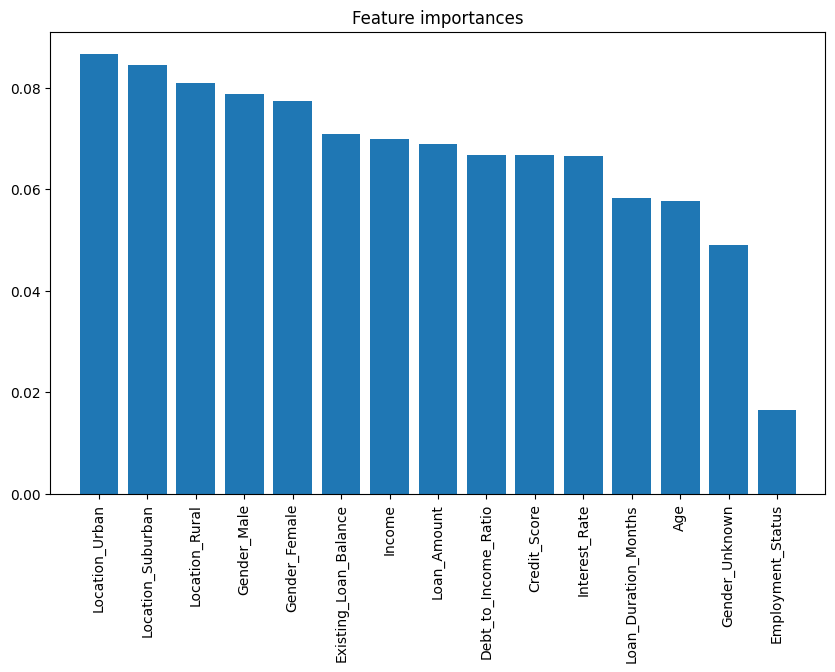

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature rankings
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Handling False Positives

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Print evaluation metrics
print(f"Accuracy: {accuracy_gb:.2f}")
print(f"Precision: {precision_gb:.2f}")
print(f"Recall: {recall_gb:.2f}")
print(f"F1 Score: {f1_gb:.2f}")
print(f"ROC-AUC Score: {roc_auc_gb:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_gb}")

Accuracy: 0.82
Precision: 0.74
Recall: 1.00
F1 Score: 0.85
ROC-AUC Score: 0.85
Confusion Matrix:
[[1034  562]
 [   2 1616]]


In [35]:
import numpy as np

# Function to adjust threshold
def adjust_threshold(probas, threshold):
    return np.where(probas >= threshold, 1, 0)

# Predict probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Adjust threshold
threshold = 0.6  # You can choose any threshold between 0 and 1
y_pred_adjusted = adjust_threshold(y_pred_proba, threshold)

# Evaluate the model with adjusted threshold
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)
roc_auc_adjusted = roc_auc_score(y_test, y_pred_proba)
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Print evaluation metrics
print(f"Accuracy: {accuracy_adjusted:.2f}")
print(f"Precision: {precision_adjusted:.2f}")
print(f"Recall: {recall_adjusted:.2f}")
print(f"F1 Score: {f1_adjusted:.2f}")
print(f"ROC-AUC Score: {roc_auc_adjusted:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_adjusted}")

Accuracy: 0.85
Precision: 0.80
Recall: 0.94
F1 Score: 0.86
ROC-AUC Score: 0.89
Confusion Matrix:
[[1214  382]
 [ 102 1516]]
